In [1]:
import os
import sys
# os.chdir("..")
sys.path.append(os.path.abspath(".."))

import torch
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import torchaudio
import glob

from model.VRNN import VRNN
from dataset.audio_dataset import AudioDataset
from utils.padding import collate_fn
from experiments.train import train, evaluate

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VRNN().to(device)

In [4]:
data_dir = "/home/onyxia/work/Dynamical-Variational-Autoencoders/data/mels_saved"
dataset = AudioDataset(data_dir)

N = len(dataset)
train_len = int(0.8 * N)
val_len = int(0.1 * N)
test_len = N - train_len - val_len

In [5]:
g = torch.Generator().manual_seed(42)

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_len, val_len, test_len],
    generator=g
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [6]:
# Récupère le premier batch
batch = next(iter(train_loader))
print("Type du batch:", type(batch))
print("Shape du batch:", batch.shape)

x0 = batch[:, 0, :]   # shape = (seq_len, mel_dim)
print("Shape séquence 0 :", x0.shape)
print(x0)

Type du batch: <class 'torch.Tensor'>
Shape du batch: torch.Size([200, 32, 80])
Shape séquence 0 : torch.Size([200, 80])
tensor([[ 0.9109,  0.5153,  0.2257,  ..., -0.5852, -0.5649, -0.4978],
        [ 1.4790,  0.8001, -0.4396,  ..., -0.4473, -0.5301, -0.4194],
        [ 1.3194, -0.1672, -0.0446,  ..., -0.4438, -0.4630, -0.4787],
        ...,
        [ 1.5046,  1.1784,  0.1558,  ..., -0.5238, -0.5163, -0.4893],
        [ 0.7753,  0.2239,  0.0688,  ..., -0.5196, -0.4722, -0.4244],
        [ 1.5197,  1.1319,  0.0090,  ..., -0.5908, -0.4546, -0.3419]])


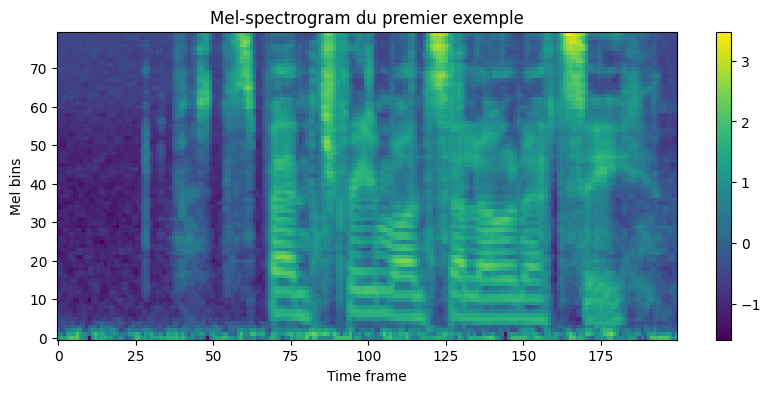

In [7]:
plt.figure(figsize=(10,4))
plt.imshow(x0.T, aspect="auto", origin="lower")
plt.colorbar()
plt.title("Mel-spectrogram du premier exemple")
plt.xlabel("Time frame")
plt.ylabel("Mel bins")
plt.show()

In [ ]:
history = train(model=model, train_loader=train_loader, val_loader=val_loader, batch_size=32, device=device)

[1/50] Train: 34.077 | Val: 28.445 | β=0.000
 → Saved BEST model
[2/50] Train: 13.939 | Val: -2.177 | β=0.100
 → Saved BEST model
[3/50] Train: -10.190 | Val: -14.737 | β=0.200
 → Saved BEST model
[4/50] Train: -16.458 | Val: -17.208 | β=0.300
 → Saved BEST model


In [1]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

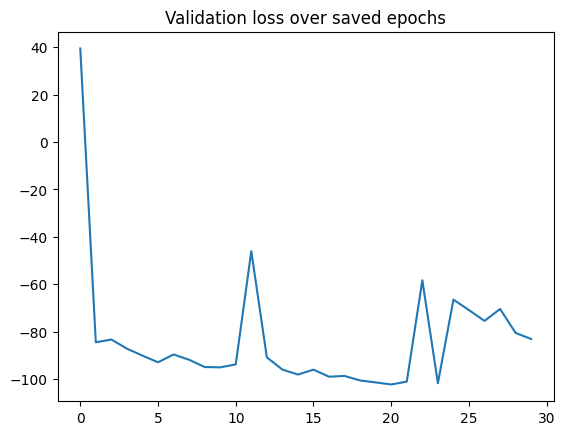

In [ ]:
# ckpts = sorted(glob.glob("vrnn_epoch*.pt"))

# val_losses = []

# for ckpt in ckpts:
#     model = VRNN()  # très important : même architecture
#     model.load_state_dict(torch.load(ckpt))
#     model.eval()

#     val_recon, val_kld = evaluate(model, val_loader)
#     val_losses.append(val_recon + val_kld)

# plt.plot(val_losses)
# plt.title("Validation loss over saved epochs")
# plt.show()
